# 01 - Analyse Exploratoire des Données (EDA)

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

%matplotlib inline

In [4]:
# Chemins robustes
ROOT = Path.cwd()
if not (ROOT / "data" / "raw" / "Online Retail.xlsx").exists():
    ROOT = ROOT.parent

DATA_PATH = ROOT / "data" / "raw" / "Online Retail.xlsx"
OUTPUT_DIR = ROOT / "outputs" / "figures"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"ROOT: {ROOT}")
print(f"DATA_PATH exists: {DATA_PATH.exists()}")

ROOT: /home/apollinaire_12/customer-segmentation
DATA_PATH exists: True


---
## 1. Chargement et contexte

In [5]:
# Chargement
df = pd.read_excel(DATA_PATH)
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")

print(f"Shape: {df.shape}")
print(f"Mémoire: {df.memory_usage(deep=True).sum() / 1e6:.1f} MB")

Shape: (541909, 8)
Mémoire: 141.5 MB


In [6]:
# Aperçu
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
105189,545217,22148,EASTER CRAFT 4 CHICKS,1,2011-02-28 16:59:00,4.13,NaN,United Kingdom
406788,571828,20914,SET/5 RED RETROSPOT LID GLASS BOWLS,10,2011-10-19 11:52:00,2.95,16440.00,United Kingdom
339951,566603,21703,BAG 125g SWIRLY MARBLES,1,2011-09-13 16:12:00,0.83,NaN,United Kingdom
113219,545916,37447,CERAMIC CAKE DESIGN SPOTTED PLATE,12,2011-03-08 11:46:00,1.49,12528.00,Germany
480482,577303,84997B,CHILDRENS CUTLERY RETROSPOT RED,3,2011-11-18 13:02:00,4.15,14390.00,United Kingdom


In [7]:
# Tableau récapitulatif contexte
context = {
    "Période": f"{df['InvoiceDate'].min().date()} → {df['InvoiceDate'].max().date()}",
    "Durée (jours)": (df['InvoiceDate'].max() - df['InvoiceDate'].min()).days,
    "Transactions": f"{len(df):,}",
    "Factures uniques": f"{df['InvoiceNo'].nunique():,}",
    "Clients uniques": f"{df['CustomerID'].nunique():,}",
    "Produits uniques": f"{df['StockCode'].nunique():,}",
    "Pays": df['Country'].nunique(),
    "Pays principal": f"{df['Country'].value_counts().index[0]} ({df['Country'].value_counts().iloc[0]/len(df)*100:.1f}%)"
}
pd.DataFrame.from_dict(context, orient='index', columns=['Valeur'])

,Valeur
Période,2010-12-01 → 2011-12-09
Durée (jours),373
Transactions,"541,909"
Factures uniques,"25,900"
Clients uniques,"4,372"
Produits uniques,"4,070"
Pays,38
Pays principal,United Kingdom (91.4%)


Commentaire :
Ce tableau résume le cadre de l’analyse : les données couvrent environ un an de 2010 à 2011 avec 541 909 lignes de transactions, 25 900 factures et 4 372 clients, et elles proviennent majoritairement du Royaume-Uni (≈91%), ce qui influencera l’interprétation des segments.


---
## 2. Qualité des données

In [8]:
# Valeurs manquantes
missing = pd.DataFrame({
    'Manquants': df.isnull().sum(),
    '%': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('%', ascending=False)
missing[missing['Manquants'] > 0]

,Manquants,%
CustomerID,135080,24.93
Description,1454,0.27


Cette sortie montre que **24,93%** des lignes n’ont pas de `CustomerID` : ces transactions peuvent encore servir à des **KPIs globaux** (volume, saisonnalité), mais elles sont **non exploitables pour le RFM et le clustering client** car on ne peut pas les rattacher à un client ; à ce niveau de manque, on privilégie donc généralement l’exclusion pour la segmentation.


In [9]:
# Anomalies
anomalies = {
    "CustomerID null": (df['CustomerID'].isnull().sum(), df['CustomerID'].isnull().mean() * 100),
    "Quantity <= 0": ((df['Quantity'] <= 0).sum(), (df['Quantity'] <= 0).mean() * 100),
    "UnitPrice <= 0": ((df['UnitPrice'] <= 0).sum(), (df['UnitPrice'] <= 0).mean() * 100),
    "Factures 'C' (annulées)": (df['InvoiceNo'].astype(str).str.startswith('C').sum(), 
                                 df['InvoiceNo'].astype(str).str.startswith('C').mean() * 100)
}
pd.DataFrame.from_dict(anomalies, orient='index', columns=['Count', '%'])

,Count,%
CustomerID null,135080,24.93
Quantity <= 0,10624,1.96
UnitPrice <= 0,2517,0.46
Factures 'C' (annulées),9288,1.71


Cette table quantifie les anomalies majeures : **24,93%** de CustomerID manquants (non rattachables à un client), **1,96%** de quantités ≤0 et **0,46%** de prix ≤0 (retours/erreurs), et **1,71%** de factures annulées (InvoiceNo commençant par “C”) ; ces points justifient un filtrage avant le calcul du RFM et du clustering.

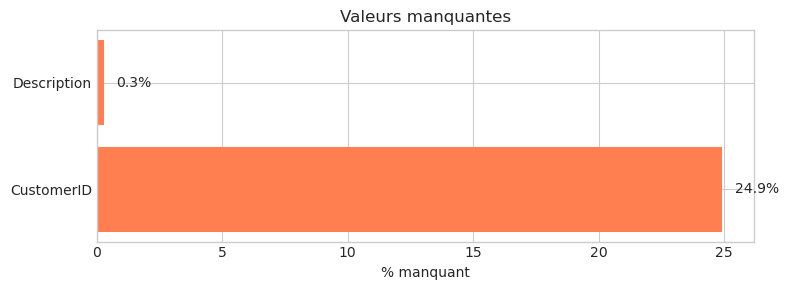

In [10]:
# Visualisation valeurs manquantes
fig, ax = plt.subplots(figsize=(8, 3))
missing_plot = missing[missing['Manquants'] > 0]
ax.barh(missing_plot.index, missing_plot['%'], color='coral')
ax.set_xlabel('% manquant')
ax.set_title('Valeurs manquantes')
for i, v in enumerate(missing_plot['%']):
    ax.text(v + 0.5, i, f'{v:.1f}%', va='center')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "01_missing_values.png", dpi=200, bbox_inches="tight")
plt.show()

### DÉCISIONS NETTOYAGE

| Anomalie | Action | Justification |
|----------|--------|---------------|
| CustomerID null (~25%) | **Supprimer** | Obligatoire pour RFM |
| Quantity ≤ 0 (~2%) | **Exclure** | Retours/annulations |
| UnitPrice ≤ 0 (~0.5%) | **Exclure** | Prix invalides |
| InvoiceNo "C..." |**Exclure**| Factures annulées |

---
## 3. KPIs 

In [11]:
# Données valides pour KPIs (hors anomalies)
df_valid = df[
    (df['CustomerID'].notna()) & 
    (df['Quantity'] > 0) & 
    (df['UnitPrice'] > 0) &
    (~df["InvoiceNo"].astype(str).str.startswith("C"))

].copy()

df_valid['TotalAmount'] = df_valid['Quantity'] * df_valid['UnitPrice']
print(f"Transactions valides: {len(df_valid):,} ({len(df_valid)/len(df)*100:.1f}%)")

Transactions valides: 397,884 (73.4%)


Commentaire : Après filtrage, il reste **397 884 lignes (73,4%)** exploitables pour calculer le montant total des transactions et construire le RFM.


In [12]:
# KPIs globaux
kpis = {
    "Revenue total (£)": f"{df_valid['TotalAmount'].sum():,.0f}",
    "Nb commandes": f"{df_valid['InvoiceNo'].nunique():,}",
    "Nb clients": f"{df_valid['CustomerID'].nunique():,}",
    "AOV (Average Order Value)": f"£{df_valid.groupby('InvoiceNo')['TotalAmount'].sum().mean():,.2f}",
    "Panier moyen par ligne": f"£{df_valid['TotalAmount'].mean():,.2f}",
    "Revenue/client moyen": f"£{df_valid.groupby('CustomerID')['TotalAmount'].sum().mean():,.2f}"
}
pd.DataFrame.from_dict(kpis, orient='index', columns=['Valeur'])

,Valeur
Revenue total (£),"8,911,408"
Nb commandes,"18,532"
Nb clients,"4,338"
AOV (Average Order Value),£480.87
Panier moyen par ligne,£22.40
Revenue/client moyen,"£2,054.27"



Sur les transactions nettoyées, le dataset représente **~£8,9M** de revenu pour **18 532** commandes et **4 338** clients, avec un **panier moyen par commande** élevé (**~£480,9**) et un **panier moyen par ligne** beaucoup plus faible (**~£22,4**), ce qui suggère des commandes composées de plusieurs lignes/articles.


In [13]:
# Revenue par pays (Top 5)
revenue_country = df_valid.groupby('Country')['TotalAmount'].sum().sort_values(ascending=False)
top5 = revenue_country.head(5)
top5_pct = (top5 / revenue_country.sum() * 100).round(1)

print("Top 5 pays par revenue:")
pd.DataFrame({'Revenue (£)': top5.apply(lambda x: f"{x:,.0f}"), '% total': top5_pct})

Top 5 pays par revenue:


,Revenue (£),% total
Country,,
United Kingdom,"7,308,392",82.00
Netherlands,"285,446",3.20
EIRE,"265,546",3.00
Germany,"228,867",2.60
France,"209,024",2.30


In [14]:
# PARETO : Concentration de valeur
customer_revenue = df_valid.groupby('CustomerID')['TotalAmount'].sum().sort_values(ascending=False)
customer_revenue_cumsum = customer_revenue.cumsum() / customer_revenue.sum() * 100

# Trouver le % de clients pour 80% du CA
n_customers = len(customer_revenue)
for pct in [10, 20, 30]:
    n_top = int(n_customers * pct / 100)
    revenue_pct = customer_revenue.head(n_top).sum() / customer_revenue.sum() * 100
    print(f"Top {pct}% clients ({n_top:,}) = {revenue_pct:.1f}% du CA")

Top 10% clients (433) = 61.3% du CA
Top 20% clients (867) = 74.6% du CA
Top 30% clients (1,301) = 82.8% du CA


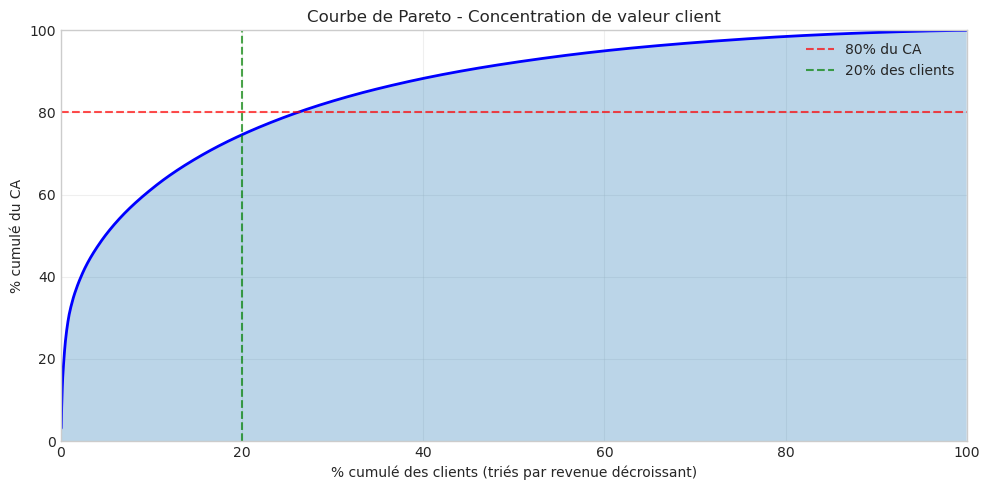

In [15]:
# Visualisation Pareto
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(1, len(customer_revenue) + 1) / len(customer_revenue) * 100
y = customer_revenue.cumsum() / customer_revenue.sum() * 100

ax.plot(x, y, 'b-', linewidth=2)
ax.axhline(80, color='red', linestyle='--', alpha=0.7, label='80% du CA')
ax.axvline(20, color='green', linestyle='--', alpha=0.7, label='20% des clients')
ax.fill_between(x, y, alpha=0.3)

ax.set_xlabel('% cumulé des clients (triés par revenue décroissant)')
ax.set_ylabel('% cumulé du CA')
ax.set_title('Courbe de Pareto - Concentration de valeur client')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "01_pareto_curve.png", dpi=200, bbox_inches="tight")
plt.show()

**Lecture** : **20%** des clients génèrent **~75%** du CA et **80%** du CA provient de **~30%** des clients.  

**Implication** : La segmentation RFM nous permettra d'identifier ces clients à haute valeur ("Champions") vs clients à risque. Le Monetary sera le plus discriminant pour identifier le top 20-30% à forte valeur. 

---
## 4. RFM

In [16]:
# Date de référence = max + 1 jour (Pour le R)
reference_date = df_valid['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"Date de référence: {reference_date}")

Date de référence: 2011-12-10 12:50:00


In [17]:
# Calcul RFM
rfm = df_valid.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalAmount': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
print(f"Shape RFM: {rfm.shape}")
rfm.sample(7)

Shape RFM: (4338, 4)


,CustomerID,Recency,Frequency,Monetary
2515,15766.00,64,1,315.06
1083,13812.00,42,3,539.00
1695,14655.00,8,4,1932.23
2149,15271.00,7,15,2507.07
1687,14644.00,68,2,830.76
838,13473.00,61,2,422.64
3149,16647.00,170,2,214.06


In [18]:
# Stats descriptives RFM
rfm[['Recency', 'Frequency', 'Monetary']].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

,Recency,Frequency,Monetary
count,4338.00,4338.00,4338.00
mean,92.54,4.27,2054.27
std,100.01,7.70,8989.23
min,1.00,1.00,3.75
1%,1.00,1.00,52.20
5%,3.00,1.00,112.31
25%,18.00,1.00,307.41
50%,51.00,2.00,674.49
75%,142.00,5.00,1661.74
95%,312.00,13.00,5841.84


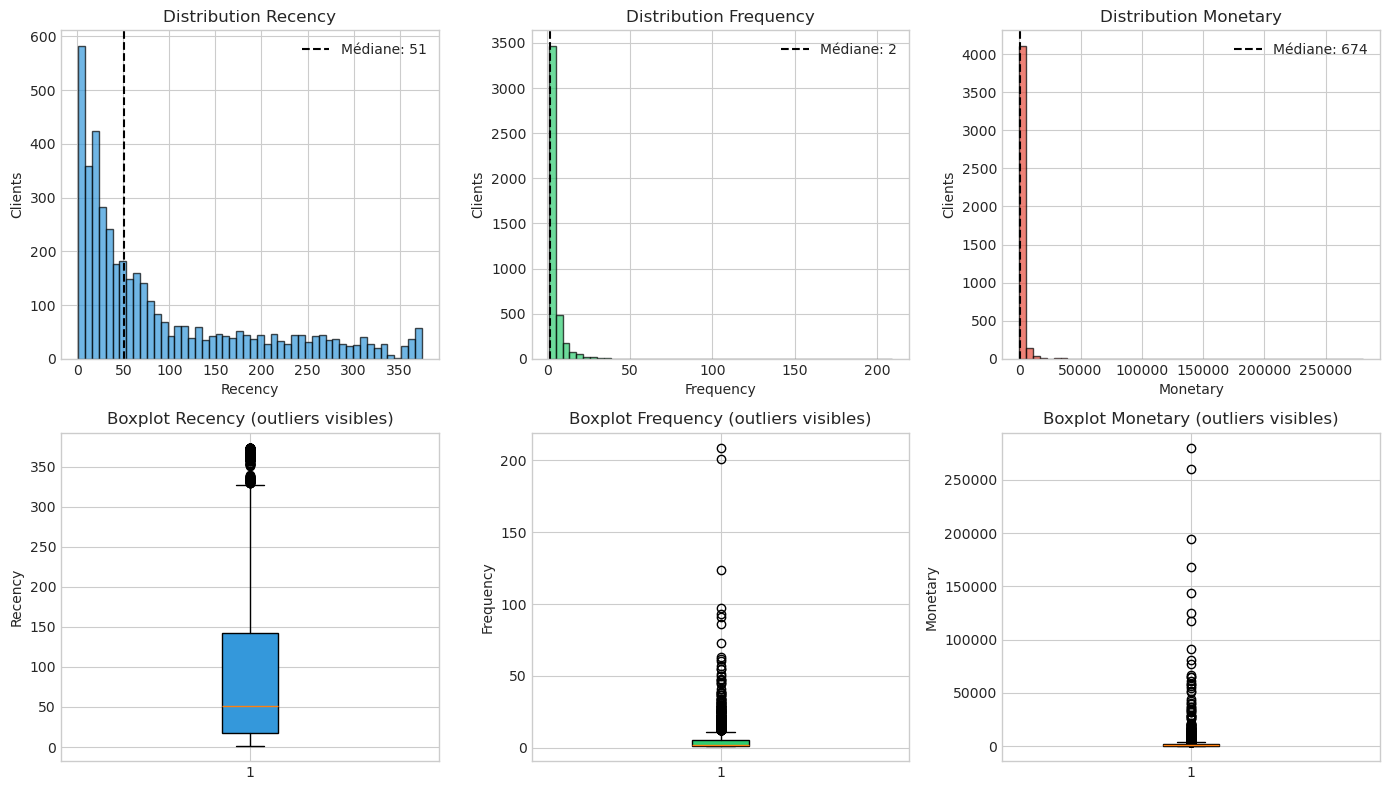

In [19]:
# Distributions RFM
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

# Row 1: Histogrammes
for ax, col, color in zip(axes[0], ['Recency', 'Frequency', 'Monetary'], ['#3498db', '#2ecc71', '#e74c3c']):
    ax.hist(rfm[col], bins=50, color=color, edgecolor='black', alpha=0.7)
    ax.axvline(rfm[col].median(), color='black', linestyle='--', label=f'Médiane: {rfm[col].median():.0f}')
    ax.set_xlabel(col)
    ax.set_ylabel('Clients')
    ax.set_title(f'Distribution {col}')
    ax.legend()

# Row 2: Boxplots
for ax, col, color in zip(axes[1], ['Recency', 'Frequency', 'Monetary'], ['#3498db', '#2ecc71', '#e74c3c']):
    bp = ax.boxplot(rfm[col], vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor(color)
    ax.set_ylabel(col)
    ax.set_title(f'Boxplot {col} (outliers visibles)')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "01_rfm_distributions.png", dpi=200, bbox_inches="tight")
plt.show()

**Recency** : La moitié des clients a acheté il y a moins de 51 jours --> base relativement active. Cependant, 25% des clients n'ont pas acheté depuis plus de 142 jours, et certains sont inactifs depuis près d'un an (max 374 jours), ce qui suggère un risque de churn à considérer.

**Frequency** : Base majoritairement occasionnelle (médiane=2 transactions par client). 75% des clients ont effectué au plus 5 achats sur les 13 mois → faible fidélité. Seuls les 5% meilleurs clients dépassent 13 transactions. Outlier max=209 (probable revendeur).

**Monetary** : La dépense médiane s'élève à 674£, mais la forte dispersion (écart-type de 8989£) révèle une inégalité importante. Le top 1% dépense plus de 19 000£, et un client atteint même 280 000£, ce qui pourrait signaler un achat B2B ou une anomalie dans les données. 




In [20]:
# Détection outliers (IQR)
def detect_outliers_iqr(series):
    Q1, Q3 = series.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((series < lower) | (series > upper)).sum()
    return outliers, outliers / len(series) * 100

print("Outliers (méthode IQR):")
for col in ['Recency', 'Frequency', 'Monetary']:
    n_out, pct_out = detect_outliers_iqr(rfm[col])
    print(f"  {col}: {n_out:,} outliers ({pct_out:.1f}%)")

Outliers (méthode IQR):
  Recency: 155 outliers (3.6%)
  Frequency: 285 outliers (6.6%)
  Monetary: 427 outliers (9.8%)


In [21]:
# Skewness (asymétrie)
print("Skewness (asymétrie):")
for col in ['Recency', 'Frequency', 'Monetary']:
    skew = rfm[col].skew()
    print(f"  {col}: {skew:.2f} {'(fortement asymétrique)' if abs(skew) > 1 else ''}")

Skewness (asymétrie):
  Recency: 1.25 (fortement asymétrique)
  Frequency: 12.07 (fortement asymétrique)
  Monetary: 19.32 (fortement asymétrique)


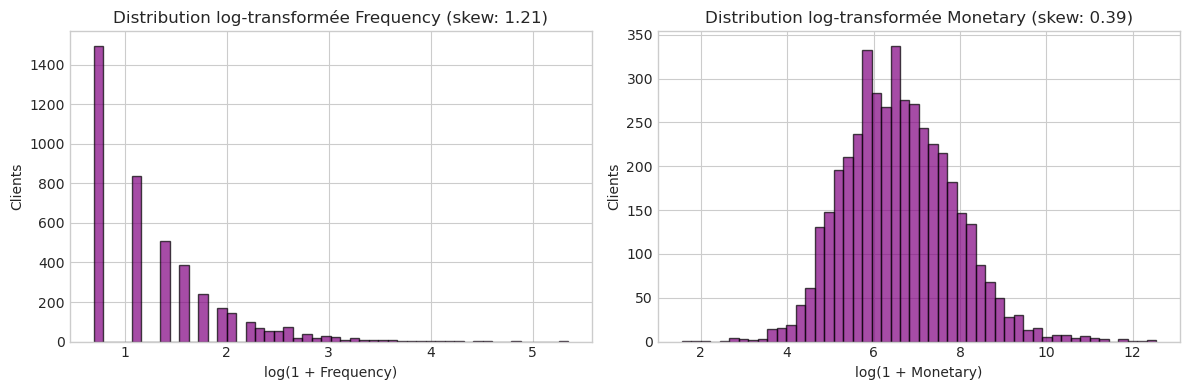

In [22]:
# Test log-transform sur Frequency et Monetary
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, col in zip(axes, ['Frequency', 'Monetary']):
    log_values = np.log1p(rfm[col])  # log(1+x) pour gérer les 0
    ax.hist(log_values, bins=50, color='purple', edgecolor='black', alpha=0.7)
    ax.set_xlabel(f'log(1 + {col})')
    ax.set_ylabel('Clients')
    ax.set_title(f'Distribution log-transformée {col} (skew: {log_values.skew():.2f})')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "01_rfm_log_transform.png", dpi=200, bbox_inches="tight")
plt.show()

Ce graphe montre que la **log-transformation** réduit fortement l’asymétrie : `Frequency` passe à une skew **1.21** et `Monetary` à **0.39**, donc les variables deviennent beaucoup plus “clustérisables” (moins dominées par les extrêmes).


---
## 5. Validation préliminaire du scaling

In [23]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [24]:
# Préparation features
X_raw = rfm[['Recency', 'Frequency', 'Monetary']].values
X_log = np.column_stack([
    rfm['Recency'].values,
    np.log1p(rfm['Frequency'].values),
    np.log1p(rfm['Monetary'].values)
])

In [25]:
# Comparaison scaling (K=4 fixe pour test rapide)
# IMPORTANT: On évalue Silhouette ET équilibre des clusters
K_TEST = 4
results = []

scalers = {
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler(),
    'MinMaxScaler': MinMaxScaler()
}

for name, scaler in scalers.items():
    # Sans log
    X_scaled = scaler.fit_transform(X_raw)
    km = KMeans(n_clusters=K_TEST, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    min_cluster_pct = pd.Series(labels).value_counts(normalize=True).min() * 100
    results.append({'Méthode': name, 'Log': 'Non', 'Silhouette': sil, 'Min_Cluster_%': min_cluster_pct})
    
    # Avec log
    X_scaled_log = scaler.fit_transform(X_log)
    labels_log = km.fit_predict(X_scaled_log)
    sil_log = silhouette_score(X_scaled_log, labels_log)
    min_cluster_pct_log = pd.Series(labels_log).value_counts(normalize=True).min() * 100
    results.append({'Méthode': name, 'Log': 'Oui', 'Silhouette': sil_log, 'Min_Cluster_%': min_cluster_pct_log})

results_df = pd.DataFrame(results)
results_pivot = results_df.pivot(index='Méthode', columns='Log', values='Silhouette')[['Non', 'Oui']]
min_cluster_pivot = results_df.pivot(index='Méthode', columns='Log', values='Min_Cluster_%')[['Non', 'Oui']]

print("Silhouette Score:")
display(results_pivot)
print("\nMin Cluster % (seuil recommandé: ≥5%):")
display(min_cluster_pivot.round(1))

Silhouette Score:


Log,Non,Oui
Méthode,,
MinMaxScaler,0.56,0.41
RobustScaler,0.74,0.37
StandardScaler,0.62,0.38



Min Cluster % (seuil recommandé: ≥5%):


Log,Non,Oui
Méthode,,
MinMaxScaler,11.50,13.90
RobustScaler,0.10,14.00
StandardScaler,0.30,12.90


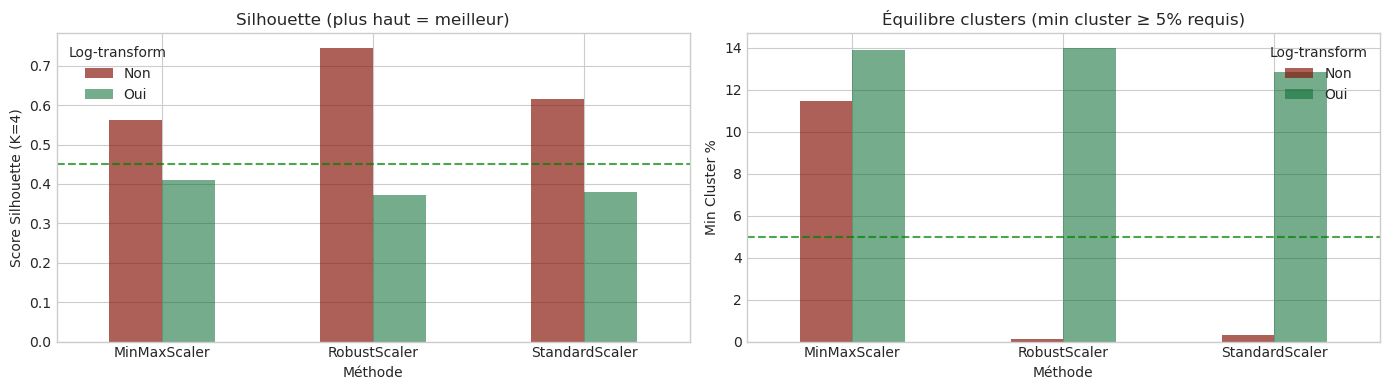

In [26]:
# Visualisation comparaison : Silhouette ET Équilibre
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Silhouette
results_pivot.plot(kind='bar', ax=axes[0], color=["#851407ac", "#096c328f"])
axes[0].set_ylabel('Score Silhouette (K=4)')
axes[0].set_title('Silhouette (plus haut = meilleur)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].legend(title='Log-transform')
axes[0].axhline(0.45, color='green', linestyle='--', alpha=0.7, label='Seuil 0.45')

# Équilibre des clusters
min_cluster_pivot.plot(kind='bar', ax=axes[1], color=["#851407ac", "#096c328f"])
axes[1].set_ylabel('Min Cluster %')
axes[1].set_title('Équilibre clusters (min cluster ≥ 5% requis)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].legend(title='Log-transform')
axes[1].axhline(5, color='green', linestyle='--', alpha=0.7, label='Seuil 5%')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "01_scaling_comparison.png", dpi=200, bbox_inches="tight")
plt.show()

**Remarque** : La Silhouette seule est trompeuse : RobustScaler sans transformation atteint 0.74 en isolant artificiellement 8 super-outliers (0.1% de la base) dans un cluster inexploitable, tandis que l'ajout de log-transform équilibre les segments mais chute à 0.37 (<0.45). La solution candidate : Winsorisation P95 + RobustScaler.

In [28]:
# Estimation finale
print("=== ESTIMATION POST-PREPROCESSING ===")
print(f"Lignes conservées: {len(df_valid):,} / {len(df):,} ({len(df_valid)/len(df)*100:.1f}%)")
print(f"Clients pour clustering: {rfm.shape[0]:,}")

=== ESTIMATION POST-PREPROCESSING ===
Lignes conservées: 397,884 / 541,909 (73.4%)
Clients pour clustering: 4,338
